# `Section` Object

The `Section` object has the following *stateful* methods:

>
>- ```.py
>  Section.setTrialSectionDeformation(e: float[2])
>  ```
> 
>- ```.py
>  Section.getStressResultant(e: float[2] = None, commit = False) ->  float[2]:
>  ```
>
>- ```.py
>  Section.getSectionTangent() -> float[2,2]
>  ```
>  
>- ```.py
>  Section.getInitialTangent() -> float[2,2]
>  ```
>  
>- ```.py
>  Section.getSectionFlexibility() -> float[2,2]
>  ```
> 
>- ```.py
>  Section.getInitialFlexibility() -> float[2,2]
>  ```
>

In [1]:
from math import cos,sin,sqrt,pi
from numpy import linspace

import opensees
import opensees.tcl

from opensees import section, layer, patch, uniaxial
from opensees.render import mpl as render

## Section Geometry

In [2]:
from opensees.units.english import *

In [3]:
HSec = 5.*ft            # Column Depth
BSec = 3.*ft            # Column Width
coverSec = 5.*inch      # Column cover to reinforcing steel NA.
numBarsSec = 4          # number of longitudinal-reinforcement bars in steel layer. (symmetric top & bot)
barAreaSec = 1*in2      # area of longitudinal-reinforcement bars
SecTag = 1              # tag = for symmetric section

# RC section: 
coverY = HSec/2.0        # Distance from section z-axis to edge of cover concrete -- outer edge of cover concrete
coverZ = BSec/2.0        # Distance from section y-axis to edge of cover concrete -- outer edge of cover concrete
coreY = coverY-coverSec  # Distance from section z-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
coreZ = coverZ-coverSec  # Distance from section y-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
nfY = 16                 # number of fibers for concrete in y-direction
nfZ = 8                  # number of fibers for concrete in z-direction

### Concrete

In [4]:
# nominal concrete compressive strength
fc = -4.0*ksi              # Concrete Compressive Strength ksi
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus

# unconfined concrete
fc1U    =  fc              # unconfined concrete (todeschini parabolic model) maximum stress
eps1U   = -0.003           # strain at maximum strength of unconfined concrete
fc2U    =  0.2*fc1U        # ultimate stress
eps2U   = -0.01            # strain at ultimate stress
_lambda =  0.1             # ratio between unloading slope at eps2 and initial slope Ec

# unconfined tensile properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets =  ftU/0.002           # tension softening stiffness

# build 'cover, concrete (unconfined)
concU = uniaxial.Concrete02(None, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets)

In [5]:
gross =  [
    patch.rect(concU, [nfZ, nfY], [[-coverZ, -coverY], [coverZ, coverY]])
]

### Reinforcement (`layer`, `fiber`)

In [6]:
Fy = 66.8*ksi      # yield stress
Es = 29000.*ksi    # modulus of steel
Bs = 0.005         # strain-hardening ratio 
R0 = 18            # control transition from elastic to plastic branches
cR1 = 0.925        # control transition from elastic to plastic branches
cR2 = 0.15         # control transition from elastic to plastic branches

# Create material for reinforcement
steel = uniaxial.Steel02(None, Fy, Es, Bs, R0, cR1, cR2)

# Create geometry for reinforcement
reinf = [
    layer.line(steel, numBarsSec, barAreaSec, [[-coreZ, coreY],[ coreZ,  coreY]]),  # top layer reinforcement
    layer.line(steel, numBarsSec, barAreaSec, [[-coreZ,-coreY],[ coreZ, -coreY]]),  # bottom layer reinfocement
]

In [7]:
sect = section.FiberSection(SecTag,  1e6, [*gross, *reinf])

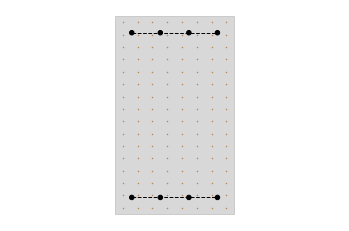

In [8]:
render.section(sect);

## Analysis

### Create a series of $\varepsilon$, $\kappa$ values

In [ ]:
import numpy as np

n = 50
crush_strain = -0.003
yield_strain =  0.002

steel_strain = linspace(crush_strain, 10.0*yield_strain, n)
curvature_A = (steel_strain - crush_strain)/(HSec - coverSec)
axial_strain_A = crush_strain + HSec/2*curvature_A


d = (HSec - 2*coverSec)
tens, comp = linspace([crush_strain, 10.0*yield_strain],
                      [yield_strain,      yield_strain], n).T

curvature_B = (tens + comp)/d
axial_strain_B = tens + d/2*curvature_B


axial_strain = np.array([*axial_strain_A, *axial_strain_B])
curvature = np.array([*curvature_A, *curvature_B])

### Get the section resultant for each of these values

In [ ]:
with sect as S:
    N, M = zip(*[
        S.getStressResultant([e,k], False)
                 for e,k in zip(axial_strain, curvature)
    ])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("typewriter")
plt.plot(M[:n], N[:n])
plt.plot(M[n:], N[n:])
plt.scatter(M[n],N[n]);

In [ ]:
def solve_axial(sect, kap, axial: float, eps0, tol=1e-6, maxiter=25):
    # Newton-Raphson iteration
    eps = eps0
    s = sect.getStressResultant([eps, kap], False)
    for i in range(maxiter):
        if abs(s[0] - axial) < tol:
            return eps
        s = sect.getStressResultant([eps, kap], False)
        eps -= (s[0] - axial)/sect.getSectionTangent()[0,0]
    return eps

In [ ]:
fig, ax = plt.subplots(1,2)

k0 = 0.0
dkap = 5e-6
for P in np.linspace(500, -8.5e6, 15):

    with sect as s:
        e = e0 = solve_axial(s,  k0,  P,  0.0)
        
        # begin with two points so we can test the increment
        # in the while-loop
        PM = [
            s.getStressResultant([e0, k0], True),
            s.getStressResultant([solve_axial(s, k0+dkap, P, e0), k0+dkap], True),
        ]

        kap = 2*dkap
        while abs(PM[-1][1]) > 0.995*abs(PM[-2][1]):
            e = solve_axial(s, kap, P, e)
            PM.append(s.getStressResultant([e, kap], True))
            kap += dkap


    p, m = zip(*PM) # extract output into two variables

    # Moment-Curvature plot
    ax[0].plot(linspace(0.0, kap, len(m)), m)

    # Locus plot
    ax[1].plot(m, p)
    ax[1].plot(M[:], N[:])

In [ ]:
print(opensees.tcl.dumps(sect))